**Instituto Tecnológico de Aeronáutica – ITA**

**Visão Computacional - CM-203**

**Professores:** 

Arthur Fernandes de Morais

Elcio Hideiti Shiguemori

Gabriel Adriano de Melo

Marcos Ricardo Omena de Albuquerque Maximo

**Orientações padrão:**

Antes de você entregar o Lab, tenha certeza de que tudo está rodando corretamente (sequencialmente): Primeiro, **reinicie o kernel** (`Runtime->Restart Runtime` no Colab ou `Kernel->Restart` no Jupyter), depois rode todas as células (`Runtime->Run All` no Colab ou `Cell->Run All` no Jupyter) e verifique que as células rodem sem erros, principalmente as de correção automática que apresentem os `assert`s.

É muito importante que vocês não apaguem as células de resposta para preenchimento, isto é, as que contenham o `ESCREVA SEU CÓDIGO AQUI` ou o `ESCREVA SUA RESPOSTA AQUI`, além das células dos `assert`, pois elas contém metadados com o id da célula para os sistemas de correção automática e manual. O sistema de correção automática executa todo o código do notebook, adicionando testes extras nas células de teste. Não tem problema vocês criarem mais células, mas não apaguem as células de correção. Mantenham a solução dentro do espaço determinado, por organização. Se por acidente acontecer de apagarem alguma célula que deveria ter a resposta, recomendo iniciar de outro notebook (ou dar um `Undo` se possível), pois infelizmente recriar a célula não resolve.

Os Notebooks foram programados para serem compatíveis com o Google Colab, instalando as dependências necessárias automaticamente a baixando os datasets necessários a cada lab. Os comandos que se iniciam por ! (ponto de exclamação) são de bash e também podem ser executados no terminal do Linux.

## Instalações e Configurações

As células a seguir instalam dependências e configuram o notebook para a realização do laboratório.

In [1]:
# This cell installs the dependencies

!pip install numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# This cell imports the needed libraries

import numpy as np
import matplotlib.pyplot as plt
from math import pi, sin, cos, inf

In [3]:
# This cell configures matplotlib

plt.rcParams.update({'font.size': 14})

In [4]:
# This cell defines a function for resetting the random seed

def reset_seed():
    np.random.seed(42) # 42 is the answer to the Ultimate Question of Life, the Universe, and Everything

## Implementação de Simulador Estocástico

Primeiramente, para entender melhor o modelo matemático usado pelo filtro de Kalman, você implementará um simulador de sistema dinâmico estocástico. Considere as equações em espaço de estados mostradas em aula:
\begin{equation}
\mathbf{x}_t = \mathbf{A} \mathbf{x}_{t-1} + \mathbf{B} \mathbf{u}_t + \mathbf{w}_t,
\end{equation}
\begin{equation}
\mathbf{z}_t = \mathbf{C} \mathbf{x}_t + \mathbf{v}_t,
\end{equation}
em que $\mathbf{A}$, $\mathbf{B}$ e $\mathbf{C}$ são matrizes, $\mathbf{x}_t$ é o estado no tempo de amostragem (instante discreto) $t$, $\mathbf{u}_t$ é a entrada de controle relativa ao tempo de amostragem $t$, e $\mathbf{w}_t$ e $\mathbf{v}_t$ são ruídos distribuídos tais que $\mathbf{w}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{Q})$ e $\mathbf{v}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{R})$.
Note que embora o filtro de Kalman considere que o sistema dinâmico pode ser variante no tempo, i.e. as matrizes que determinam o sistema podem mudar com o tempo, estaremos considerando aqui um sistema invariante no tempo por simplicidade.

Na célula a seguir, define-se a classe `StochasticDynamicalSystemSimulator` para representar o simulador de sistema dinâmico estocástico.

In [5]:
class StochasticDynamicalSystemSimulator:
    """
    Represents a stochastic dynamical system simulator.
    """
    def __init__(self, A, B, C, Q, R, x0):
        """
        Initializes the simulator.
        :param A: the state transition matrix.
        :param B: the input matrix.
        :param C: the observation matrix.
        :param Q: the covariance matrix of the process noise.
        :param R: the covariance matrix of the observation noise.
        :param x0: the initial state of the simulation.
        """
        self.A = A
        self.B = B
        self.C = C
        self.Q = Q
        self.R = R
        self.x = x0

Para permitir simulações a fim de testar a implementação, define-se matrizes associados um simples sistema cinemático de 1 dimensão:
\begin{equation}
\mathbf{x}_t = 
\begin{bmatrix}
x_t \\ \dot{x}_t
\end{bmatrix},
\end{equation}
\begin{equation}
\mathbf{A} = 
\begin{bmatrix}
1 & T \\ 0 & 1
\end{bmatrix},
\end{equation}
\begin{equation}
\mathbf{B} = 
\begin{bmatrix}
T^2/2 \\ T,
\end{bmatrix},
\end{equation}
\begin{equation}
\mathbf{C} = 
\begin{bmatrix}
1 & 0
\end{bmatrix},
\end{equation}
em que $T$ é o tempo de amostragem. Conforme comentado em sala, para determinar $\mathbf{Q}$, adota-se um ruído no comando gaussiano com média zero e covariância $\mathbf{M}$, e então calcula-se
\begin{equation}
\mathbf{Q} = \mathbf{B} \mathbf{M} \mathbf{B}^T.
\end{equation}
Além disso, tem-se
\begin{equation}
\mathbf{M} = \sigma_{\mathrm{acc}}^2,
\end{equation}
\begin{equation}
\mathbf{R} = \sigma_{\mathrm{cam}}^2,
\end{equation}
em que $\sigma_{\mathrm{acc}}$ e $\sigma_{\mathrm{cam}}$ são as variâncias associadas com as incertezas na aceleração e na observação, respectivamente.

In [6]:
def get_system_1d(T, sigma_acc, sigma_cam):
    """
    Obtains a stochastic dynamical system based on kinematics equations along a single axis 
    whose states are 1D position and velocity, and the input is 1D acceleration. Moreover, the
    observation is the position.
    :return A: the state transition matrix.
    :return B: the input matrix.
    :return C: the observation matrix.
    :return Q: the covariance matrix of the process noise.
    :return R: the covariance matrix of the observation noise.
    """
    A = np.array([[1.0, T], [0.0, 1.0]])
    B = np.array([[T ** 2 / 2.0], [T]])
    C = np.array([[1.0, 0.0]])
    M = np.array([[sigma_acc ** 2]])
    Q = B @ M @ B.T
    R = np.array([[sigma_cam ** 2]])
    return A, B, C, Q, R

A seguir, implemente o método `step()` (da classe `StochasticDynamicalSystemSimulator`), que executa um passo de simulação de acordo com
\begin{equation}
\mathbf{x}_t = \mathbf{A} \mathbf{x}_{t-1} + \mathbf{B} \mathbf{u}_t + \mathbf{w}_t.
\end{equation}
Dica: para gerar o ruído $\mathbf{w}_t$, use a função `np.random.multivariate_normal()` do NumPy. Considerando as convenções adotadas no laboratório, deve-se chamar a função da seguinte forma:

`np.random.multivariate_normal(np.zeros(state_dim), covariance, 1)`,

em que `state_dim` é a dimensão do vetor de estados, `covariance` é a matriz de covariância (no caso, $\mathbf{Q}$) e o último argumento indica que será gerada apenas 1 amostra aleatória.

In [7]:
def step(self, u : np.ndarray):
    """
    Steps the simulation.
    :param u: the control input.
    :return: updated state after the step.
    """
    w = np.random.multivariate_normal(np.zeros(len(self.x)),self.Q,1).T
    self.x = self.A @ self.x+ self.B @ u +w
    return self.x

# Adding the step() method to the StochasticDynamicalSystemSimulator class
StochasticDynamicalSystemSimulator.step = step

In [8]:
T = 0.1
sigma_acc = 2.0
sigma_cam = 0.9
x0 = np.array([[0.1], [1.0]])
u = np.array([[1.0]])
reset_seed()
A, B, C, Q, R = get_system_1d(T, sigma_acc, sigma_cam)

simulator = StochasticDynamicalSystemSimulator(A, B, C, Q, R, x0)
x = simulator.step(u)
print(x)
assert np.max(np.abs(x - np.array([[0.20003286], [1.00065717]]))) < 1e-3

[[0.20003286]
 [1.00065717]]


O código a seguir, realiza 100 simulações de Monte Carlo, realizando 100 passos de simulação em cada simulação de Monte Carlo. Com isso, ilustra-se a evolução do sistema dinâmico estocástico. Usa-se o modelo cinemático 1D.

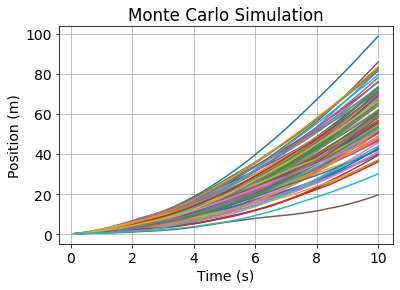

In [9]:
T = 0.1
sigma_acc = 2.0
sigma_cam = 0.9
x0 = np.array([[0.1], [1.0]])
u = np.array([[1.0]])
reset_seed()
A, B, C, Q, R = get_system_1d(T, sigma_acc, sigma_cam)

num_mc = 100
num_steps = 100
time = T * np.arange(num_steps) + T
x_history = np.zeros((A.shape[0], num_steps))
plt.figure()
for m in range(num_mc):
    simulator = StochasticDynamicalSystemSimulator(A, B, C, Q, R, x0)
    for i in range(num_steps):
        x_history[:, i] = simulator.step(u).T
    plt.plot(time, x_history[0, :])
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Monte Carlo Simulation')
plt.grid()

In [45]:
def observe(self):
    """
    Obtains an observation.
    :return: an observation of the system.
    """
    v = np.random.multivariate_normal(np.zeros(len(self.C@self.x)),self.R,1).T
    z = self.C @ self.x +v
    return z

# Adding the observe() method to the StochasticDynamicalSystemSimulator class
StochasticDynamicalSystemSimulator.observe = observe

In [47]:
T = 0.1
sigma_acc = 2.0
sigma_cam = 0.9
x0 = np.array([[0.1], [1.0]])
u = np.array([[1.0]])
z = np.array([[3.0]])
A, B, C, Q, R = get_system_1d(T, sigma_acc, sigma_cam)
reset_seed()

simulator = StochasticDynamicalSystemSimulator(A, B, C, Q, R, x0)
z = simulator.observe()
assert np.max(np.abs(z - np.array([[0.54704274]]))) < 1e-3
print(z)

[[0.54704274]]


A célula a seguir gera 10000 observações. Mostra-se um histograma das medidas, além de estatísticas de média e de variância.

Mean:  0.09807761496841642
Std:  0.9030709855169888


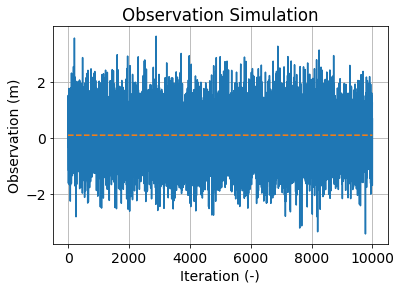

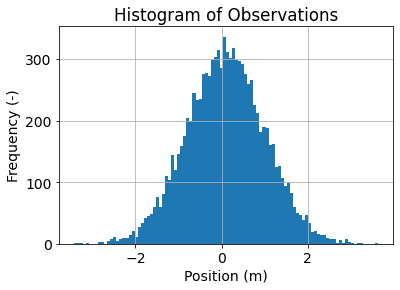

In [48]:
T = 0.1
sigma_acc = 2.0
sigma_cam = 0.9
x0 = np.array([[0.1], [1.0]])
z = np.array([[3.0]])
A, B, C, Q, R = get_system_1d(T, sigma_acc, sigma_cam)
reset_seed()

num_steps = 10000
z_history = np.zeros((C.shape[0], num_steps))
plt.figure()
simulator = StochasticDynamicalSystemSimulator(A, B, C, Q, R, x0)
for i in range(num_steps):
    z_history[:, i] = simulator.observe()
plt.plot(z_history[0, :])
plt.plot(np.mean(z_history[0, :]) * np.ones_like(z_history[0, :]), '--')
plt.grid()
plt.xlabel('Iteration (-)')
plt.ylabel('Observation (m)')
plt.title('Observation Simulation')

plt.figure()
plt.grid()
plt.hist(z_history[0, :], 100)
plt.xlabel('Position (m)')
plt.ylabel('Frequency (-)')
plt.title('Histogram of Observations')

print('Mean: ', np.mean(z_history[0, :]))
print('Std: ', np.std(z_history[0, :]))

A seguir, define-se um filtro de Kalman. O filtro de Kalman consiste de dois passos: predição e filtragem. O passo de predição é dado pelas seguintes equações:
\begin{equation}
\hat{\mathbf{x}}^-_t = \mathbf{A} \hat{\mathbf{x}}_{t-1}^+ + \mathbf{B} \mathbf{u}_t,
\end{equation}
\begin{equation}
\mathbf{P}^-_t = \mathbf{A} \mathbf{P}^+_{t-1} \mathbf{A}^T + \mathbf{Q},
\end{equation}
em que $\hat{\mathbf{x}}^-_t$ e $\mathbf{P}^-_t$ representam, respectivamente, a média e a covariância da estimativa no tempo de amostragem $t$, antes de incorporar a observação. Já o passo de filtragem é dado pelas seguintes equações:
\begin{equation}
\mathbf{K}_t = \mathbf{P}^-_t \mathbf{C}^T (\mathbf{R} + \mathbf{C} \mathbf{P}^-_t \mathbf{C}^T)^{-1},
\end{equation}
\begin{equation}
\hat{\mathbf{x}}^+_t = \hat{\mathbf{x}}^-_t + \mathbf{K}_t (\mathbf{z}_t - \mathbf{C} \hat{\mathbf{x}}^-_t),
\end{equation}
\begin{equation}
\mathbf{P}^+_t = \mathbf{P}^-_t - \mathbf{K}_t \mathbf{C} \mathbf{P}^-_t,
\end{equation}
em que $\hat{\mathbf{x}}^+_t$ e $\mathbf{P}^+_t$ são, respectivamente, a média e a covariância da estimativa no tempo de amostragem $t$, após incorporar a observação.

In [49]:
class KalmanFilter:
    """
    This class represents a Kalman filter. It considers a 
    time-invariant stochastic dynamical system as its model.
    """
    def __init__(self, A, B, C, Q, R, x0, P0):
        """
        Initializes the Kalman filter.
        :param A: the state transition matrix.
        :param B: the input matrix.
        :param C: the observation matrix.
        :param Q: the covariance matrix of the process noise.
        :param R: the covariance matrix of the observation noise.
        :param x0: the initial mean of the estimate.
        :param P0: the initial covariance matrix of the estimate.
        """
        self.A = A
        self.B = B
        self.C = C
        self.Q = Q
        self.R = R
        self.reset(x0, P0)
        
    def reset(self, x0, P0):
        """
        Resets the filter.
        :param x0: the new mean of the estimate after the reset.
        :param P0: the covariance matrix of the estimate after the reset.
        """
        self.x = x0
        self.P = P0

A seguir, implemente o método `predict()`, que realiza um passo de predição do filtro de Kalman.

In [50]:
def predict(self, u : np.ndarray):
    """
    Executes a prediction step.
    :param u: the control input.
    :return x: updated mean of the estimate.
    :return P: updated covariance matrix of the estimate.
    """
    self.x = self.A@self.x+self.B@u
    self.P = self.A@self.P@self.A.T+self.Q
    return self.x, self.P

# Adding the predict() method to the KalmanFilter class
KalmanFilter.predict = predict

In [51]:
T = 0.1
sigma_acc = 2.0
sigma_cam = 0.9
x0 = np.array([[0.1], [1.0]])
P0 = np.identity(2)
u = np.array([[1.0]])
A, B, C, Q, R = get_system_1d(T, sigma_acc, sigma_cam)
reset_seed()

filter = KalmanFilter(A, B, C, Q, R, x0, P0)
filter.predict(u)
print(filter.x)
print(filter.P)
assert np.max(np.abs(filter.x - np.array([[0.205], [1.1]]))) < 1e-3
assert np.max(np.abs(filter.P - np.array([[1.0101, 0.102], [0.102,  1.04]]))) < 1e-3

[[0.205]
 [1.1  ]]
[[1.0101 0.102 ]
 [0.102  1.04  ]]


O código a seguir realiza um experimento em que um filtro de Kalman é inicializado com o mesmo estado do simulador, mas a estimativa é atualizada apenas com passos de predição. Desse modo, a estimativa tende a divergir do estado real ao longo do tempo, pois não há correções através de observações. Chama-se este fenômeno de *drift* (deriva).

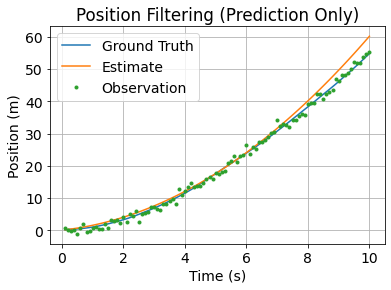

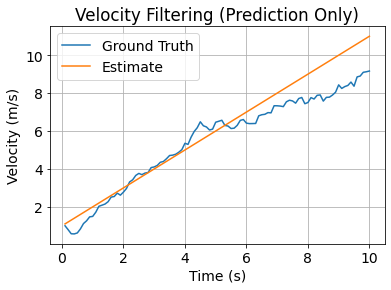

In [52]:
T = 0.1
sigma_acc = 2.0
sigma_cam = 0.9
x0 = np.array([[0.1], [1.0]])
P0 = np.identity(2)
u = np.array([[1.0]])
A, B, C, Q, R = get_system_1d(T, sigma_acc, sigma_cam)
reset_seed()

num_steps = 100
time = T * np.arange(num_steps) + T
x_history = np.zeros((A.shape[0], num_steps))
z_history = np.zeros((C.shape[0], num_steps))
xhat_history = np.zeros((A.shape[0], num_steps))
simulator = StochasticDynamicalSystemSimulator(A, B, C, Q, R, x0)
filter = KalmanFilter(A, B, C, Q, R, x0, P0)
for i in range(num_steps):
    x_history[:, i] = simulator.step(u).T
    z_history[:, i] = simulator.observe()
    xhat, _ = filter.predict(u)
    xhat_history[:, i] = xhat.T
    
plt.figure()
plt.plot(time, x_history[0, :])
plt.plot(time, xhat_history[0, :])
plt.plot(time, z_history[0, :], '.')
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position Filtering (Prediction Only)')
plt.legend(['Ground Truth', 'Estimate', 'Observation'])

plt.figure()
plt.plot(time, x_history[1, :])
plt.plot(time, xhat_history[1, :])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Filtering (Prediction Only)')
plt.legend(['Ground Truth', 'Estimate'])

A seguir, implemente o método `filter()`, que realiza um passo de filtragem do filtro de Kalman.

In [56]:
def filter(self, z):
    """
    Executes a filtering step.
    :param z: observation.
    :return x: updated mean of the estimate.
    :return P: updated covariance matrix of the estimate.
    """
    k = self.P@self.C.T@np.linalg.inv(self.R+self.C@self.P@+self.C.T)
    self.x = self.x+k@(z-self.C@self.x)
    self.P = self.P-k@self.C@self.P
    return self.x, self.P

# Adding the filter() method to the KalmanFilter class
KalmanFilter.filter = filter

In [57]:
T = 0.1
sigma_acc = 2.0
sigma_cam = 0.9
x0 = np.array([[0.1], [1.0]])
P0 = np.identity(2)
z = np.array([[3.0]])
A, B, C, Q, R = get_system_1d(T, sigma_acc, sigma_cam)
reset_seed()

filter = KalmanFilter(A, B, C, Q, R, x0, P0)
filter.filter(z)
print(filter.x)
print(filter.P)
assert np.max(np.abs(filter.x - np.array([[1.70220994], [1.0]]))) < 1e-3
assert np.max(np.abs(filter.P - np.array([[0.44751381, 0.0], [0.0,  1.0]]))) < 1e-3

[[1.70220994]
 [1.        ]]
[[0.44751381 0.        ]
 [0.         1.        ]]


A seguir, realiza-se uma simulação do filtro de Kalman completo, considerando passos de predição e de atualização. Neste caso, considera-se que o filtro tem acesso ao comando de controle $\mathbf{u}_t$. A estimativa da observação da velocidade é obtida por derivação numérica:
\begin{equation}
\dot{x}_t \approx \frac{x_t - x_{t-1}}{T}.
\end{equation}
Perceba como o filtro de Kalman tem um desempenho muito superior na estimativa de velocidade, quando comparado a uma derivação numérica. Conforme discutido em sala, derivação tende a amplificar ruído.

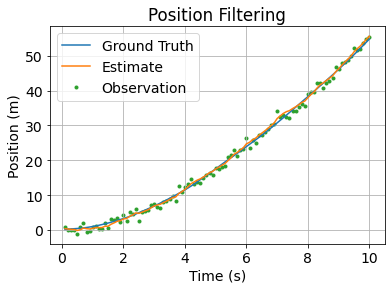

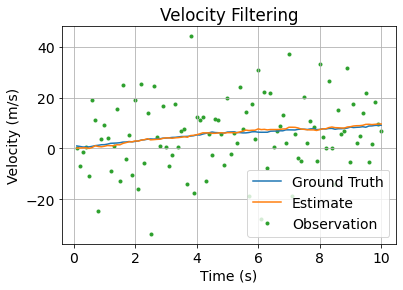

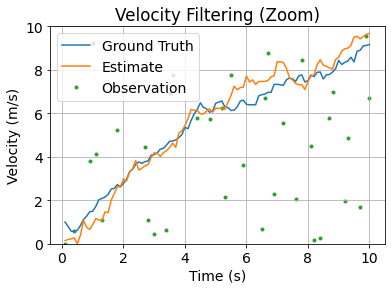

In [58]:
T = 0.1
sigma_acc = 2.0
sigma_cam = 0.9
x0 = np.array([[0.1], [1.0]])
x0_filter = np.array([[0.0], [0.0]]) # so the filter starts with a wrong estimate
P0 = np.identity(2)
u = np.array([[1.0]])
A, B, C, Q, R = get_system_1d(T, sigma_acc, sigma_cam)
reset_seed()

num_steps = 100
time = T * np.arange(num_steps) + T
x_history = np.zeros((A.shape[0], num_steps))
z_history = np.zeros((C.shape[0], num_steps))
dz_history = np.zeros((C.shape[0], num_steps))
xhat_history = np.zeros((A.shape[0], num_steps))
simulator = StochasticDynamicalSystemSimulator(A, B, C, Q, R, x0)
filter = KalmanFilter(A, B, C, Q, R, x0_filter, P0)
for i in range(num_steps):
    x_history[:, i] = simulator.step(u).T
    z_history[:, i] = simulator.observe()
    filter.predict(u)
    xhat, _ = filter.filter(z_history[:, i])
    xhat_history[:, i] = xhat.T

plt.figure()
plt.plot(time, x_history[0, :])
plt.plot(time, xhat_history[0, :])
plt.plot(time, z_history[0, :], '.', zorder=-1)
dz_history[0, 1:] = (1.0 / T) * np.diff(z_history[0, :])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position Filtering')
plt.legend(['Ground Truth', 'Estimate', 'Observation'])

plt.figure()
plt.plot(time, x_history[1, :])
plt.plot(time, xhat_history[1, :])
plt.plot(time, dz_history[0, :], '.', zorder=-1)
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Filtering')
plt.legend(['Ground Truth', 'Estimate', 'Observation'])

plt.figure()
plt.plot(time, x_history[1, :])
plt.plot(time, xhat_history[1, :])
plt.plot(time, dz_history[0, :], '.', zorder=-1)
plt.ylim(0, 10)
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Filtering (Zoom)')
plt.legend(['Ground Truth', 'Estimate', 'Observation'])

Como discutido em sala, na prática, em um problema de rastreamento (*tracking*), o rastreador não tem acesso ao comando de controle, de modo que se considera $\mathbf{u}_t=\mathbf{0}$. A seguir, a mesma simulação da célula anterior é repetida, porém assumindo que o filtro recebe $\mathbf{u}_t=\mathbf{0}$ no passo de predição, que não condiz com a aceleração efetivamente realizada pelo alvo. Esse descasamento entre o filtro e a realidade faz com que o filtro demore mais a convergir no caso da célula a seguir em comparação com o da anterior, como pode ser observado especialmente no último gráfico mostrado (gráfico da velocidade com *zoom*).

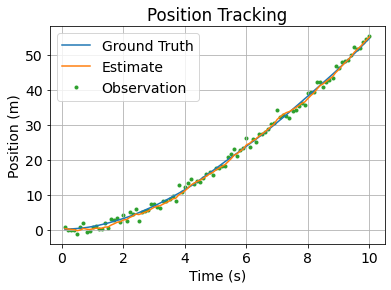

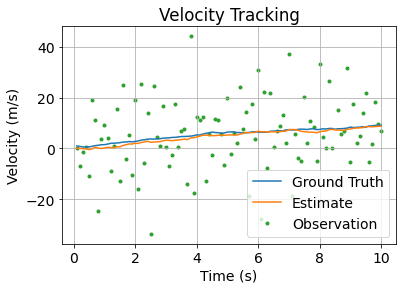

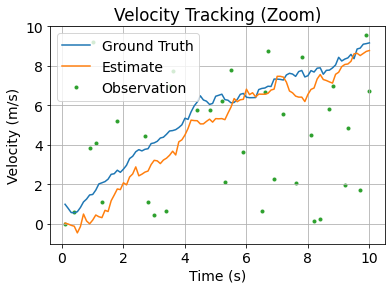

In [59]:
T = 0.1
sigma_acc = 2.0
sigma_cam = 0.9
x0 = np.array([[0.1], [1.0]])
x0_filter = np.array([[0.0], [0.0]]) # so the filter starts with a wrong estimate
P0 = np.identity(2)
u = np.array([[1.0]])
A, B, C, Q, R = get_system_1d(T, sigma_acc, sigma_cam)
reset_seed()

num_steps = 100
time = T * np.arange(num_steps) + T
x_history = np.zeros((A.shape[0], num_steps))
z_history = np.zeros((C.shape[0], num_steps))
dz_history = np.zeros((C.shape[0], num_steps))
xhat_history = np.zeros((A.shape[0], num_steps))
simulator = StochasticDynamicalSystemSimulator(A, B, C, Q, R, x0)
filter = KalmanFilter(A, B, C, Q, R, x0_filter, P0)
for i in range(num_steps):
    x_history[:, i] = simulator.step(u).T
    z_history[:, i] = simulator.observe().T
    filter.predict(np.array([[0.0]]))
    xhat, _ = filter.filter(z_history[:, i])
    xhat_history[:, i] = xhat.T

plt.figure()
plt.plot(time, x_history[0, :])
plt.plot(time, xhat_history[0, :])
plt.plot(time, z_history[0, :], '.', zorder=-1)
dz_history[0, 1:] = (1.0 / T) * np.diff(z_history[0, :])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position Tracking')
plt.legend(['Ground Truth', 'Estimate', 'Observation'])

plt.figure()
plt.plot(time, x_history[1, :])
plt.plot(time, xhat_history[1, :])
plt.plot(time, dz_history[0, :], '.', zorder=-1)
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Tracking')
plt.legend(['Ground Truth', 'Estimate', 'Observation'])

plt.figure()
plt.plot(time, x_history[1, :])
plt.plot(time, xhat_history[1, :])
plt.plot(time, dz_history[0, :], '.', zorder=-1)
plt.ylim(-1, 10)
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Tracking (Zoom)')
plt.legend(['Ground Truth', 'Estimate', 'Observation'])

Conforme apresentado em sala, em um problema de rastreamento de um objeto numa imagem, costuma-se usar um modelo cinemático 2D, em que o vetor de estados contém posições e velocidades nos eixos $x$ e $y$:
\begin{equation}
\mathbf{x}_t = 
\begin{bmatrix}
x_t \\ y_t \\ \dot{x}_t \\ \dot{y}_t
\end{bmatrix}.
\end{equation}

Com isso, o espaço de estados geralmente usado é dado por
\begin{equation}
\mathbf{A} = 
\begin{bmatrix}
1 & 0 & T & 0 \\
0 & 1 & 0 & T \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix},
\end{equation}
\begin{equation}
\mathbf{B} = 
\begin{bmatrix}
\dfrac{T^2}{2} & 0 \\
0 & \dfrac{T^2}{2} \\
T & 0 \\
0 & T
\end{bmatrix},
\end{equation}
\begin{equation}
\mathbf{C} = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix},
\end{equation}
\begin{equation}
\mathbf{M} =
\begin{bmatrix}
\sigma^2_{\mathrm{acc}} & 0 \\
0 & \sigma^2_{\mathrm{acc}}
\end{bmatrix},
\end{equation}
\begin{equation}
\mathbf{Q} =
\mathbf{B} \mathbf{M} \mathbf{B}^T,
\end{equation}
\begin{equation}
\mathbf{R} =
\begin{bmatrix}
\sigma^2_{\mathrm{cam}} & 0 \\
0 & \sigma^2_{\mathrm{cam}}
\end{bmatrix}.
\end{equation}

In [65]:
from traitlets.traitlets import TCPAddress
def get_system_2d(T, sigma_acc, sigma_cam):
    """
    Obtains a stochastic dynamical system based on kinematics equations along a single axis 
    whose states are 2D position and velocity, and the input is 2D acceleration. Moreover, the
    observation is the 2D position.
    :return A: the state transition matrix.
    :return B: the input matrix.
    :return C: the observation matrix.
    :return Q: the covariance matrix of the process noise.
    :return R: the covariance matrix of the observation noise.
    """
    A = np.array([[1, 0, T, 0],[0, 1, 0, T],[0, 0, 1, 0],[0, 0, 0, 1]])
    B = np.array([[T**2 /2,0],[0,T**2 /2],[T,0],[0,T]])
    C = np.array([[1,0,0,0],[0,1,0,0]])
    M = np.array([[sigma_acc**2,0],[0,sigma_acc**2]])
    R = np.array([[sigma_cam**2,0],[0,sigma_cam**2]])
    Q = B@M@B.T
    return A, B, C, Q, R

In [66]:
T = 0.1
sigma_acc = 2.0
sigma_cam = 0.9
x0 = np.array([[0.0],
               [0.0],
               [0.0],
               [0.0]])
P0 = np.identity(4)
u = np.array([[1.0],
              [1.0]])
A, B, C, Q, R = get_system_2d(T, sigma_acc, sigma_cam)
reset_seed()

simulator = StochasticDynamicalSystemSimulator(A, B, C, Q, R, x0)
x = simulator.step(u)
print(x)
assert np.max(np.abs(x - np.array([[3.28589601e-05], [3.61735584e-03], [6.57169373e-04], [7.23471398e-02]]))) < 1e-3
z = simulator.observe()
print(z)
assert np.max(np.abs(z - np.array([[-0.21070518], [-0.20710591]]))) < 1e-3

[[3.28590084e-05]
 [3.61735572e-03]
 [6.57169371e-04]
 [7.23471398e-02]]
[[-0.21070518]
 [-0.20710591]]


No experimento da célula a seguir, verifica-se o funcionamento de um rastreador 2D baseado em filtro de Kalman. Simula-se 500 passos de simulação com $T = 0{,}1 \ s$. Nos instantes $t \in [270, 300)$, simula-se perda da detecção do objeto (que pode ocorrer devido a uma oclusão, por exemplo), de modo que o filtro permanece apenas realizando passos de predição. Destaca-se que o filtro é capaz de manter uma estimativa razoável até que a detecção retorne.

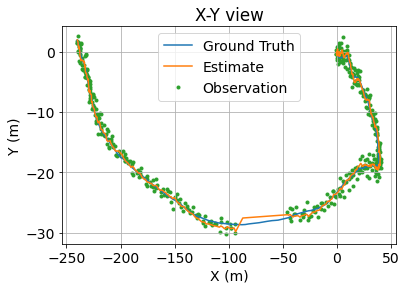

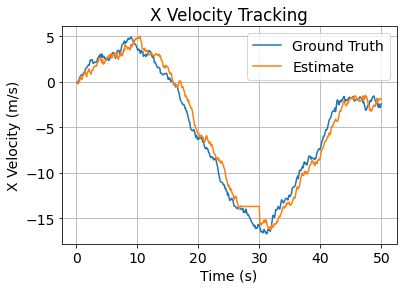

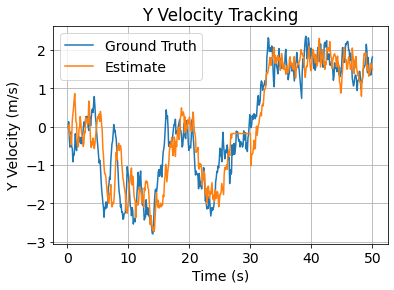

In [67]:
T = 0.1
sigma_acc = 2.0
sigma_cam = 0.9
x0 = np.array([[0.0],
               [0.0],
               [0.0],
               [0.0]])
P0 = np.identity(4)
u = np.array([[1.0],
              [1.0]])
A, B, C, Q, R = get_system_2d(T, sigma_acc, sigma_cam)
reset_seed()

num_steps = 500
time = T * np.arange(num_steps) + T
x_history = np.zeros((A.shape[0], num_steps))
z_history = np.zeros((C.shape[0], num_steps))
dz_history = np.zeros((C.shape[0], num_steps))
xhat_history = np.zeros((A.shape[0], num_steps))
simulator = StochasticDynamicalSystemSimulator(A, B, C, Q, R, x0)
filter = KalmanFilter(A, B, C, Q, R, x0, P0)
for i in range(num_steps):
    t = i * T
    u[0, 0] = sin(t / (2.0 * pi) + pi / 2.0)
    u[1, 0] = sin(t / (2.0 * pi) * t)
    x_history[:, i] = simulator.step(u)[:, 0]
    z_history[:, i] = simulator.observe()[:, 0]
    x, _ = filter.predict(np.array([[0.0], [0.0]]))
    if i >= 270 and i < 300:
        z_history[:, i] = np.array([inf, inf])
    else:
        filter.filter(np.array([z_history[:, i]]).T)
    xhat_history[:, i] = (filter.x)[:, 0]
    
plt.figure()
plt.plot(x_history[0, :], x_history[1, :])
plt.plot(xhat_history[0, :], xhat_history[1, :])
plt.plot(z_history[0, :], z_history[1, :], '.', zorder=-1)
plt.grid()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('X-Y view')
plt.legend(['Ground Truth', 'Estimate', 'Observation'])

plt.figure()
plt.plot(time, x_history[2, :])
plt.plot(time, xhat_history[2, :])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('X Velocity (m/s)')
plt.title('X Velocity Tracking')
plt.legend(['Ground Truth', 'Estimate'])

plt.figure()
plt.plot(time, x_history[3, :])
plt.plot(time, xhat_history[3, :])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Y Velocity (m/s)')
plt.title('Y Velocity Tracking')
plt.legend(['Ground Truth', 'Estimate'])